In [1]:
import pandas as pd
from konlpy.tag import Okt
from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from sklearn.decomposition import LatentDirichletAllocation
import pyLDAvis
from gensim import corpora
from gensim.models import LdaModel
import pyLDAvis.gensim_models as gensimvis
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [2]:
# 토픽모델링
df = pd.read_excel('review (1).xlsx')

def table(df):
    totalreview=[]
    totalreview.append(df.iloc[0,1]) #전체리뷰수
    totalreview.append(df.iloc[0,3]) #판매량
    totalreview.append(df.iloc[2:,4].mean()) #별점 평균

    review=df.iloc[2:,1] #리뷰내용
    reviewtotal=[] #전체 리뷰내용을 하나의 열로 만들기 위해서 리스트로 저장.
    for n in review:
        reviewtotal.append(n)
    totalreview.append(reviewtotal)
    colname=['전체리뷰수','판매량','별점평균','리뷰']
    newdf=pd.DataFrame([totalreview],columns=colname)
    # newdf = newdf.explode('리뷰')
    return newdf

totaldf=table(df) 

for n in range(2,22):
    df=pd.read_excel(f'review ({n}).xlsx')
    adddf=table(df)
    if n ==2:
        finaldf=pd.concat([totaldf,adddf])
    else:
        finaldf=pd.concat([finaldf,adddf])

# finaldf = finaldf.explode('리뷰')

finaldf['리뷰'] = finaldf['리뷰'].apply(lambda x: ' '.join(x)) #리스트로 되어있는거를 풀어주기.

#판매량 중간값 라벨링
middle=finaldf.판매량.median() 
finaldf['라벨'] = finaldf['판매량'].apply(lambda x: 1 if x > middle else 0)

In [3]:
finaldf

,전체리뷰수,판매량,별점평균,리뷰,라벨
0,304,103,4.858553,배송이 일단 빨라서 좋았어요\n제품도 살짝 넉넉하고 너무 좋아요\n고민하다 구매하길...,0
0,665,369,4.845113,아까 입고서 너무 이뻐가지고 아까워서 못입고 걸어놓기만 햤아요!!\n옷도 이쁘고 사...,1
0,622,64,4.807074,잘받앗어요\n크게입고싶어서 큰사이즈햇는데좀마니커요\n그래도이뿌요 오버핏... 길이가...,0
0,221,214,4.714932,같은 상품인데 배송일짜에따라 사이즈가 있고없는게 조금 낯설었어요~~저희아들은 천천히...,1
0,428,403,4.752336,카키 M사이즈 빠른 배송 정말 감사합니다!\n올 가을 이거 자주 입을 거에요!\n입...,1
0,1064,600,4.765038,172 에 52 남학생 s추천받았는데 성장기라 m으로 했는데 조금 넉넉하니 좋아요...,1
0,117,99,4.760684,주문하고 3일동안 발송 얘기가 없어서 문의 하니 재고가 없다고 하시고 그날 바로 배...,0
0,890,381,4.748315,리뷰보고 샀는데 생각보다 도톰하고 기장도 좀 기네요 가오리 핏으로 어떤 체형이든 잘...,1
0,355,167,4.743662,160안되는 크지 않은키 인데 궁둥이가려요\n주문하기전에 질문했었는데 크게 나온편이...,0
0,167,720,4.820359,사이즈부터 쇼핑백 이런것들 많이 물어봤는데 친절하게 답해주시고 배송 늦어지는것도 연...,1


In [4]:
okt = Okt()
box = []
boxAd=[]
for i in tqdm(finaldf.리뷰) :
    a = okt.normalize(i)
    m = okt.nouns(a)
    box.append(' '.join(m))
    for word, tag in okt.pos(a): 
        if tag == 'Adjective':
            boxAd.append(word)

100%|██████████| 21/21 [00:18<00:00,  1.16it/s]


In [5]:
# 감성점수 저장하기.
# total=[]
# senti=pd.read_csv('../data/knu_sentiment_lexicon.csv')

# total_score=[]
# for i in tqdm(finaldf['리뷰']):
#     t=okt.normalize(i)
#     score=0
#     for w, p in zip(senti['word'],senti['polarity']):
#         score+=t.count(w)*p
#     total_score.append(score)

# finaldf['감성점수']=total_score 

In [6]:
boxAd

['좋았어요',
 '넉넉하고',
 '좋아요',
 '예쁘네요',
 '같습니다',
 '이쁘네요',
 '좋아요',
 '저렴한',
 '같아요',
 '같은',
 '이쁘네요',
 '괜찮을거',
 '같아요',
 '있어요',
 '이뻐요',
 '있어요',
 '좋을듯',
 '좋아요',
 '좋아요',
 '편하게',
 '입을수',
 '있어요',
 '잘맞아요',
 '얇아요',
 '이뻐요',
 '좋네요',
 '원하는',
 '좋아요',
 '입을듯',
 '이뻐요',
 '이쁘죠',
 '빠르고',
 '예쁘네요',
 '만족합니다',
 '예뻐요',
 '빠르고',
 '좋고',
 '빨랐습니다',
 '없어요',
 '이쁘네요',
 '안되지만',
 '곱니다',
 '이쁘고',
 '적당하고',
 '있어서',
 '편하고',
 '좋아요',
 '빠른',
 '뻔했네요',
 '예쁩니다',
 '적당하고',
 '예쁘네요',
 '있네요',
 '가능할듯',
 '이쁘고',
 '입을듯',
 '좋아요',
 '예뻐요',
 '흔하지만',
 '편하게',
 '좋습니다',
 '편하고',
 '좋네요',
 '같은',
 '많은',
 '같아요',
 '비싼듯',
 '얇지도',
 '예쁘네요',
 '편합니다',
 '잘맞아요',
 '이쁩니다',
 '짧아',
 '이쁨니다',
 '없는데',
 '짧고',
 '만족해',
 '비싸지만',
 '좋',
 '좋아요',
 '빠르고',
 '이쁩니다',
 '잘맞아요',
 '이뻐서',
 '좋아요',
 '있어요',
 '만족스러워요',
 '입니다',
 '딱좋음',
 '좋아요',
 '좋아하네요',
 '그런지',
 '같은',
 '길었으면',
 '있는데',
 '이쁘네요',
 '작을까',
 '좋아요',
 '만족해요',
 '입을께요',
 '예쁘다고',
 '좋아하네요',
 '예뻐요',
 '빠르고',
 '이뻐요',
 '있는',
 '불편할',
 '있지만',
 '적당한',
 '좋아해요',
 '같아요',
 '만족합니다',
 '있어서',
 '빠르고',
 '좋아요',
 '같네요',
 '넉넉하게',
 '잘맞네요',
 '선명하고',
 '깔끔하고',
 

In [7]:
cv = CountVectorizer()
dtm = cv.fit_transform(box)

In [8]:
lda = LatentDirichletAllocation(n_components = 10)
lda.fit(dtm)
for n, i in enumerate(lda.components_) :
    idx = np.argsort(i)[::-1][:5]
    topic = cv.get_feature_names_out()[idx]
    print(f'topic {n+1} : {topic}')

topic 1 : ['학원' '일출' '음날' '바로다' '착오']
topic 2 : ['학원' '일출' '음날' '바로다' '착오']
topic 3 : ['학원' '일출' '음날' '바로다' '착오']
topic 4 : ['학원' '일출' '음날' '바로다' '착오']
topic 5 : ['학원' '일출' '음날' '바로다' '착오']
topic 6 : ['사이즈' '배송' '생각' '구매' '주문']
topic 7 : ['학원' '일출' '음날' '바로다' '착오']
topic 8 : ['배송' '사이즈' '구매' '가격' '아들']
topic 9 : ['배송' '사이즈' '생각' '아주' '지금']
topic 10 : ['배송' '사이즈' '버핏' '생각' '구매']


In [9]:
finaldf

,전체리뷰수,판매량,별점평균,리뷰,라벨
0,304,103,4.858553,배송이 일단 빨라서 좋았어요\n제품도 살짝 넉넉하고 너무 좋아요\n고민하다 구매하길...,0
0,665,369,4.845113,아까 입고서 너무 이뻐가지고 아까워서 못입고 걸어놓기만 햤아요!!\n옷도 이쁘고 사...,1
0,622,64,4.807074,잘받앗어요\n크게입고싶어서 큰사이즈햇는데좀마니커요\n그래도이뿌요 오버핏... 길이가...,0
0,221,214,4.714932,같은 상품인데 배송일짜에따라 사이즈가 있고없는게 조금 낯설었어요~~저희아들은 천천히...,1
0,428,403,4.752336,카키 M사이즈 빠른 배송 정말 감사합니다!\n올 가을 이거 자주 입을 거에요!\n입...,1
0,1064,600,4.765038,172 에 52 남학생 s추천받았는데 성장기라 m으로 했는데 조금 넉넉하니 좋아요...,1
0,117,99,4.760684,주문하고 3일동안 발송 얘기가 없어서 문의 하니 재고가 없다고 하시고 그날 바로 배...,0
0,890,381,4.748315,리뷰보고 샀는데 생각보다 도톰하고 기장도 좀 기네요 가오리 핏으로 어떤 체형이든 잘...,1
0,355,167,4.743662,160안되는 크지 않은키 인데 궁둥이가려요\n주문하기전에 질문했었는데 크게 나온편이...,0
0,167,720,4.820359,사이즈부터 쇼핑백 이런것들 많이 물어봤는데 친절하게 답해주시고 배송 늦어지는것도 연...,1


In [10]:
filt=finaldf.라벨==0
zerodf=finaldf[filt] #라벨이 0인 df를 다시 만든다.
filt2=finaldf.라벨==1
onedf=finaldf[filt2] #라벨이 1인 df를 다시 만든다.

In [11]:
def make_result(df):
    total=[]
    for i in tqdm(df['리뷰'].dropna()):
        t=okt.normalize(i)
        nouns=okt.nouns(t)
        total+=nouns
    stop_words=['사이즈','배송','바람막이','버핏','생각','구매','아주','주문','지금','조금','제품','크게','살짝','이즈','정사','약간','대비','듭니']
    total=[i for i in total if i not in stop_words]
    total=[i for i in total if len(i)>=2]
    from collections import Counter
    result=Counter(total)
    return result
zeroresult=make_result(zerodf)
onedfresult=make_result(onedf)

100%|██████████| 10/10 [00:06<00:00,  1.49it/s]


c:\Users\Administrator\anaconda3\envs\ag5\lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


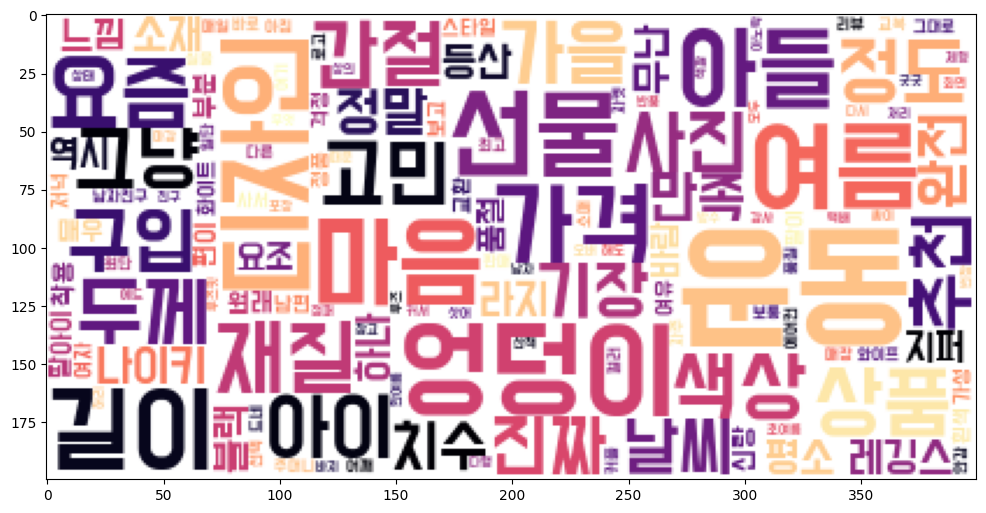

In [13]:

wc = WordCloud(background_color='white',font_path='BMDOHYEON_ttf.ttf',colormap='magma') #배달의민족 도현체를 쓰겠다.
plt.figure(figsize=(12, 8))
cloud=wc.generate_from_frequencies(zeroresult) #빈도를 기준으로 생성한다.
plt.imshow(cloud)

c:\Users\Administrator\anaconda3\envs\ag5\lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


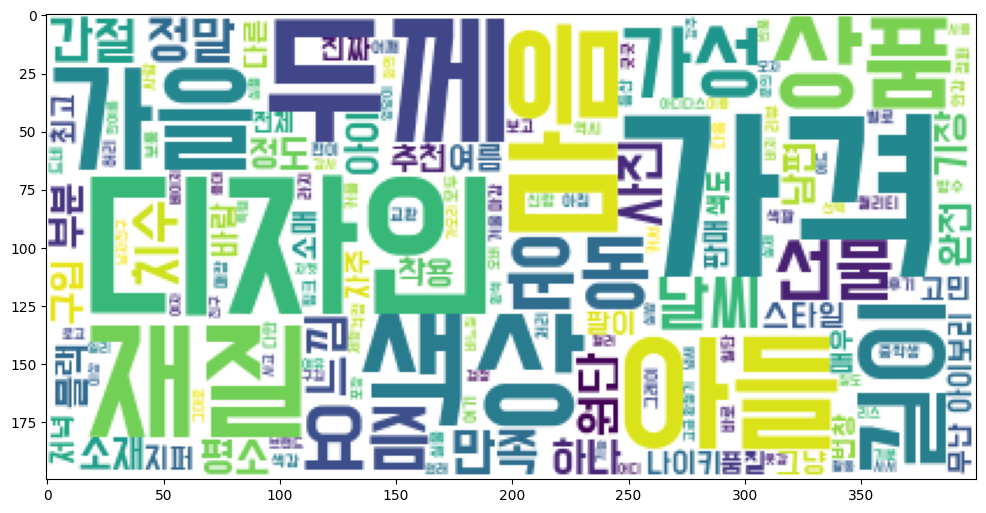

In [14]:

wc = WordCloud(background_color='white',font_path='BMDOHYEON_ttf.ttf') 
plt.figure(figsize=(12, 8))
cloud=wc.generate_from_frequencies(onedfresult) #빈도를 기준으로 생성한다.
plt.imshow(cloud)

In [ ]:
zeroresult.most_common(20)

[('운동', 171),
 ('엉덩이', 102),
 ('디자인', 91),
 ('마음', 86),
 ('여름', 85),
 ('선물', 84),
 ('길이', 74),
 ('아들', 71),
 ('가격', 70),
 ('재질', 56),
 ('요즘', 55),
 ('상품', 53),
 ('색상', 50),
 ('간절', 49),
 ('두께', 49),
 ('구입', 45),
 ('아이', 45),
 ('정도', 44),
 ('고민', 43),
 ('가을', 43)]

In [ ]:
onedfresult.most_common(20)

[('가격', 350),
 ('디자인', 245),
 ('두께', 194),
 ('색상', 162),
 ('아들', 159),
 ('재질', 157),
 ('마음', 153),
 ('가을', 136),
 ('상품', 125),
 ('길이', 115),
 ('운동', 112),
 ('가성', 104),
 ('요즘', 101),
 ('선물', 101),
 ('날씨', 99),
 ('간절', 91),
 ('만족', 90),
 ('정말', 87),
 ('치수', 87),
 ('사진', 83)]

In [ ]:
df=finaldf.iloc[:,3:]

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# 데이터 전처리
X = df['리뷰'].astype(str)
y = df['라벨']
le = LabelEncoder()
y = le.fit_transform(y)

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 텍스트 벡터화
max_words = 1000
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_train_pad = pad_sequences(X_train_seq)
X_test_pad = pad_sequences(X_test_seq)

# 모델 구성
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=128, input_length=X_train_pad.shape[1]))
model.add(LSTM(64))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# 모델 훈련
model.fit(X_train_pad, y_train, epochs=100, batch_size=32, validation_split=0.1)

Epoch 1/100
1/1 [==============================] - 5s 5s/step - loss: 0.6926 - accuracy: 0.3571 - val_loss: 0.7051 - val_accuracy: 0.0000e+00
Epoch 2/100
1/1 [==============================] - 2s 2s/step - loss: 0.6840 - accuracy: 0.7857 - val_loss: 0.7100 - val_accuracy: 0.0000e+00
Epoch 3/100
1/1 [==============================] - 3s 3s/step - loss: 0.6752 - accuracy: 0.8571 - val_loss: 0.7157 - val_accuracy: 0.0000e+00
Epoch 4/100
1/1 [==============================] - 2s 2s/step - loss: 0.6655 - accuracy: 0.9286 - val_loss: 0.7224 - val_accuracy: 0.0000e+00
Epoch 5/100
1/1 [==============================] - 2s 2s/step - loss: 0.6547 - accuracy: 0.9286 - val_loss: 0.7305 - val_accuracy: 0.0000e+00
Epoch 6/100
1/1 [==============================] - 3s 3s/step - loss: 0.6421 - accuracy: 0.9286 - val_loss: 0.7404 - val_accuracy: 0.0000e+00
Epoch 7/100
1/1 [==============================] - 3s 3s/step - loss: 0.6275 - accuracy: 0.9286 - val_loss: 0.7528 - val_accuracy: 0.0000e+00
Epoch 

In [ ]:
new_review_text = "개같은거 이걸 돈주고 팔아요? 꺼지세요"

# 전처리: 토큰화, 벡터화, 패딩 등의 전처리 수행
new_review_seq = tokenizer.texts_to_sequences([new_review_text])
new_review_pad = pad_sequences(new_review_seq, maxlen=X_train_pad.shape[1])

# 모델 예측
predicted_sales_prob = model.predict(new_review_pad)

# 판매량으로 해석 (이진 분류의 경우 예시)
threshold = 0.5  # 이 임계값을 조절하여 판매 여부를 결정
predicted_sales = 1 if predicted_sales_prob > threshold else 0

print(f"모델의 예측 판매 여부: {predicted_sales}")

1/1 [==============================] - 1s 504ms/step
모델의 예측 판매 여부: 1


In [ ]:
new_review_text = "사이즈가 작아요. 두께가 너무 두꺼워요 너무 더워요 활동성이 떨어져요"

# 전처리: 토큰화, 벡터화, 패딩 등의 전처리 수행
new_review_seq = tokenizer.texts_to_sequences([new_review_text])
new_review_pad = pad_sequences(new_review_seq, maxlen=X_train_pad.shape[1])

# 모델 예측
predicted_sales_prob = model.predict(new_review_pad)

# 판매량으로 해석 (이진 분류의 경우 예시)
threshold = 0.5  # 이 임계값을 조절하여 판매 여부를 결정
predicted_sales = 1 if predicted_sales_prob > threshold else 0

print(f"모델의 예측 판매 여부: {predicted_sales}")

1/1 [==============================] - 0s 165ms/step
모델의 예측 판매 여부: 1


In [ ]:
new_review_text = "작아요 색깔이 너무 옛날것같아요"

# 전처리: 토큰화, 벡터화, 패딩 등의 전처리 수행
new_review_seq = tokenizer.texts_to_sequences([new_review_text])
new_review_pad = pad_sequences(new_review_seq, maxlen=X_train_pad.shape[1])

# 모델 예측
predicted_sales_prob = model.predict(new_review_pad)

# 판매량으로 해석 (이진 분류의 경우 예시)
threshold = 0.5  # 이 임계값을 조절하여 판매 여부를 결정
predicted_sales = 1 if predicted_sales_prob > threshold else 0

print(f"모델의 예측 판매 여부: {predicted_sales}")

1/1 [==============================] - 0s 169ms/step
모델의 예측 판매 여부: 1


In [ ]:
df

,리뷰,라벨
0,배송이 일단 빨라서 좋았어요\n제품도 살짝 넉넉하고 너무 좋아요\n고민하다 구매하길...,0
0,아까 입고서 너무 이뻐가지고 아까워서 못입고 걸어놓기만 햤아요!!\n옷도 이쁘고 사...,1
0,잘받앗어요\n크게입고싶어서 큰사이즈햇는데좀마니커요\n그래도이뿌요 오버핏... 길이가...,0
0,같은 상품인데 배송일짜에따라 사이즈가 있고없는게 조금 낯설었어요~~저희아들은 천천히...,1
0,카키 M사이즈 빠른 배송 정말 감사합니다!\n올 가을 이거 자주 입을 거에요!\n입...,1
0,172 에 52 남학생 s추천받았는데 성장기라 m으로 했는데 조금 넉넉하니 좋아요...,1
0,주문하고 3일동안 발송 얘기가 없어서 문의 하니 재고가 없다고 하시고 그날 바로 배...,0
0,리뷰보고 샀는데 생각보다 도톰하고 기장도 좀 기네요 가오리 핏으로 어떤 체형이든 잘...,1
0,160안되는 크지 않은키 인데 궁둥이가려요\n주문하기전에 질문했었는데 크게 나온편이...,0
0,사이즈부터 쇼핑백 이런것들 많이 물어봤는데 친절하게 답해주시고 배송 늦어지는것도 연...,1


In [ ]:
# 명사와 형용사 추출
df['Nouns'], df['Adjectives'] = zip(*df['리뷰'].apply(extract_nouns_adjectives))

# Tokenizer를 사용하여 단어를 숫자로 변환
tokenizer = Tokenizer()
tokenizer.fit_on_texts(high_words)
tokenizer.fit_on_texts(low_words)

# 텍스트를 숫자 시퀀스로 변환
X_high = tokenizer.texts_to_sequences(high_words)
X_low = tokenizer.texts_to_sequences(low_words)

# 레이블 데이터 생성
y_high = [1] * len(X_high)
y_low = [0] * len(X_low)

# 시퀀스 길이를 맞춰줌
max_len = 100  # 예시로 임의의 시퀀스 길이 설정
X_high = pad_sequences(X_high, maxlen=max_len)
X_low = pad_sequences(X_low, maxlen=max_len)

# LSTM 모델 정의
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=128, input_length=max_len))
model.add(LSTM(units=128))
model.add(Dense(1, activation='sigmoid'))

# 모델 컴파일
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# 모델 학습 (두 데이터셋을 합쳐서 사용)
model.fit(np.vstack((X_high, X_low)), np.hstack((y_high, y_low)), epochs=5, batch_size=32, validation_split=0.2)

Epoch 1/5
901/901 [==============================] - 84s 91ms/step - loss: 0.4156 - accuracy: 0.8545 - val_loss: 1.8734 - val_accuracy: 0.0000e+00
Epoch 2/5
901/901 [==============================] - 92s 102ms/step - loss: 0.3645 - accuracy: 0.8540 - val_loss: 1.8728 - val_accuracy: 0.0392
Epoch 3/5
901/901 [==============================] - 97s 108ms/step - loss: 0.3085 - accuracy: 0.8904 - val_loss: 2.0552 - val_accuracy: 0.0382
Epoch 4/5
901/901 [==============================] - 77s 85ms/step - loss: 0.2854 - accuracy: 0.8921 - val_loss: 2.2140 - val_accuracy: 0.0232
Epoch 5/5
901/901 [==============================] - 96s 107ms/step - loss: 0.2709 - accuracy: 0.8942 - val_loss: 2.6667 - val_accuracy: 0.0217


In [ ]:
from collections import Counter

# 1에 해당하는 행들만 선택
high_rows = df[df['라벨'] == 1]
low_rows = df[df['라벨'] == 0]

# 모든 단어를 담을 리스트
high_words = []
low_words = []

# 각 행의 내용을 단어로 분리하여 리스트에 추가
for idx, row in high_rows.iterrows():
    words_in_row = row['리뷰'].split()  # 여기서는 공백 기준으로 단어를 분리
    high_words.extend(words_in_row)

# 단어 빈도를 계산
word_counts = Counter(high_words)

for idx, row in low_rows.iterrows():
    words_in_row = row['리뷰'].split()  # 여기서는 공백 기준으로 단어를 분리
    low_words.extend(words_in_row)
    
word_counts1 = Counter(low_words)

# 단어 빈도 출력
print("판매량 높은 단어 빈도:", word_counts)
print("판매량 낮은 단어 빈도:", word_counts1)

판매량 높은 단어 빈도: Counter({'잘': 566, '좋아요': 556, '너무': 537, '딱': 285, '입기': 272, '좀': 213, '생각보다': 203, '맘에': 191, '좋고': 180, '빠르고': 178, '배송도': 171, '배송': 171, '아주': 167, '입고': 152, '더': 147, '이뻐요': 143, '이쁘고': 142, '사이즈': 139, '만족합니다': 137, '핏도': 137, '예뻐요': 129, '좋은': 122, '같아요': 119, '조금': 114, '좋네요': 113, '옷': 112, '편하게': 109, '많이': 108, '마음에': 106, '좋습니다': 106, '가격대비': 103, '핏이': 100, '옷이': 97, '살짝': 96, '약간': 95, '것': 94, '감사합니다': 94, '샀는데': 92, 'ㅎㅎ': 88, '사이즈도': 86, '넘': 86, '지금': 83, '예쁘고': 75, '입으면': 74, '정말': 72, '다': 71, '좋아요.': 70, '있어서': 68, '아들이': 67, '들어요': 67, '디자인도': 64, '입으려고': 64, '디자인': 64, '크게': 64, '옷은': 63, '요즘': 62, '입을': 61, '수': 60, '가볍고': 58, '가을에': 58, '제가': 58, '한치수': 58, '좋습니다.': 57, '가성비': 57, '가격에': 57, '이쁘네요': 56, '편하고': 56, '엄청': 55, '옷도': 54, '맞고': 54, '제품': 54, '배송이': 52, '굿': 52, '바람막이': 51, '빠른배송': 51, '완전': 50, '만족합니다.': 50, '사이즈가': 50, '재질도': 49, '빠른': 49, '오버핏으로': 48, '배송빠르고': 48, '날씨에': 48, '잘입고': 47, '그래도': 47, '저렴하게': 47, '운동할때': 47, '평소': 46, '

In [ ]:
new_review_text = "개같은거 너무 작아요 제엔장"

# 새로운 리뷰 토큰화 및 패딩
new_review_seq = tokenizer.texts_to_sequences([new_review_text])
new_review_pad = pad_sequences(new_review_seq, maxlen=max_len)

# 모델을 사용하여 예측
prediction = model.predict(new_review_pad)

# 판매량 라벨링
sales_label = 1 if prediction >= 0.5 else 0

print(f"예측된 판매량 라벨: {sales_label}")

1/1 [==============================] - 0s 20ms/step
예측된 판매량 라벨: 1


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# 데이터 전처리
# df는 데이터프레임, X는 특성 변수(리뷰, 명사, 형용사 등), y는 라벨 변수
# 아래는 예시로 '리뷰' 컬럼을 특성 변수로 사용하는 경우입니다. 원하는 특성 변수를 선택하여 사용하세요.
X = df['리뷰']
y = df['라벨']

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 텍스트 데이터를 벡터화 (여기서는 간단하게 CountVectorizer를 사용)
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

# 로지스틱 회귀 모델 생성 및 훈련
model = LogisticRegression()
model.fit(X_train_vectorized, y_train)

# 테스트 데이터에 대한 예측
y_pred = model.predict(X_test_vectorized)

# 정확도 출력
accuracy = accuracy_score(y_test, y_pred)
print(f"테스트 정확도: {accuracy}")

# 분류 보고서 출력
print(classification_report(y_test, y_pred))

테스트 정확도: 0.6
              precision    recall  f1-score   support

           0       1.00      0.50      0.67         4
           1       0.33      1.00      0.50         1

    accuracy                           0.60         5
   macro avg       0.67      0.75      0.58         5
weighted avg       0.87      0.60      0.63         5



In [ ]:
# 새로운 리뷰에 대한 예측
new_review_text ="사이즈가 작아요. 두께가 너무 두꺼워요 너무 더워요 활동성이 떨어져요"
new_review_vectorized = vectorizer.transform([new_review_text])
prediction = model.predict(new_review_vectorized)

# 예측 결과 출력
print(f"예측 라벨: {prediction[0]}")

예측 라벨: 0


In [ ]:
# 새로운 리뷰에 대한 예측
new_review_text ="개같은거 이걸 돈주고 팔아요? 꺼지세요"
new_review_vectorized = vectorizer.transform([new_review_text])
prediction = model.predict(new_review_vectorized)

# 예측 결과 출력
print(f"예측 라벨: {prediction[0]}")

예측 라벨: 0


In [ ]:
new_review_text ="너무 잘맞아요 예뻐요"
new_review_vectorized = vectorizer.transform([new_review_text])
prediction = model.predict(new_review_vectorized)

# 예측 결과 출력
print(f"예측 라벨: {prediction[0]}")

예측 라벨: 0


In [ ]:
new_review_text ="가격도 싸고 너무 좋아요 핏이 딱맞네요 정사이즈에요"
new_review_vectorized = vectorizer.transform([new_review_text])
prediction = model.predict(new_review_vectorized)

# 예측 결과 출력
print(f"예측 라벨: {prediction[0]}")

예측 라벨: 0
